# Visual Cortex Model based on Biological Neural Network

V1 <- input

Thick stripe <- V1

MT <- thick stripe, V1

VIP <- MT

MST <- MT, VIP


Interstripe <- V1

Thin stripe <- V1


LIP <- MST


V4 <- MT, Interstripe, Thin Stripe

PIT <- V4, MST, LIP

CIT <- PIT, V4


7A <- LIP, MST

AIT <- CIT, 7A




## Tim's Attempt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

### Define the Visual Cortex inspired model using PyTorch with corrected information flow

In [ ]:
class VisualCortexModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        """
        Build a neural network inspired by the visual cortex information flow.
        Corrected pathways based on the diagram analysis:

        V1 <- input
        Thick stripe <- V1
        MT <- thick stripe, V1
        VIP <- MT
        MST <- MT, VIP
        Interstripe <- V1
        Thin stripe <- V1
        LIP <- MST
        V4 <- MT, Interstripe, Thin Stripe
        PIT <- V4, MST, LIP
        CIT <- PIT, V4
        7A <- LIP, MST
        AIT <- CIT, 7A

        Args:
            input_channels: Number of input channels (1 for grayscale, 3 for RGB)
            num_classes: Number of classification categories
        """
        super(VisualCortexModel, self).__init__()

        # Primary visual cortex (V1) - detects simple features like edges and orientations
        self.v1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # V1 specialized regions
        # Thick stripe - specialized for motion and depth
        self.thick_stripe = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Interstripe - specialized for color and form
        self.interstripe = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Thin stripe - specialized for color
        self.thin_stripe = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # MT (V5) - motion processing (gets input from thick stripe and directly from V1)
        self.mt = nn.Sequential(
            nn.Conv2d(64 + 32, 48, kernel_size=3, padding=1),  # Inputs: V1 + Thick stripe
            nn.ReLU()
        )

        # VIP - visual-vestibular integration (from MT)
        self.vip = nn.Sequential(
            nn.Conv2d(48, 32, kernel_size=3, padding=1),  # Input: MT
            nn.ReLU()
        )

        # MST - motion integration (gets input from MT and VIP)
        self.mst = nn.Sequential(
            nn.Conv2d(48 + 32, 40, kernel_size=3, padding=1),  # Inputs: MT + VIP
            nn.ReLU()
        )

        # LIP - lateral intraparietal area (from MST)
        self.lip = nn.Sequential(
            nn.Conv2d(40, 32, kernel_size=3, padding=1),  # Input: MST
            nn.ReLU()
        )

        # V4 - color and form processing (from MT, Interstripe, and Thin stripe)
        self.v4 = nn.Sequential(
            nn.Conv2d(48 + 32 + 32, 48, kernel_size=3, padding=1),  # Inputs: MT + Interstripe + Thin stripe
            nn.ReLU()
        )

        # Ventral stream - "what" pathway (object recognition)
        # PIT - posterior inferotemporal cortex (from V4, MST, and LIP)
        self.pit = nn.Sequential(
            nn.Conv2d(48 + 40 + 32, 48, kernel_size=3, padding=1),  # Inputs: V4 + MST + LIP
            nn.ReLU()
        )

        # CIT - central inferotemporal cortex (from PIT and V4)
        self.cit = nn.Sequential(
            nn.Conv2d(48 + 48, 54, kernel_size=3, padding=1),  # Inputs: PIT + V4
            nn.ReLU()
        )

        # 7A - higher visual processing (from LIP and MST)
        self.area_7a = nn.Sequential(
            nn.Conv2d(32 + 40, 48, kernel_size=3, padding=1),  # Inputs: LIP + MST
            nn.ReLU()
        )

        # AIT - anterior inferotemporal cortex (from CIT and 7A)
        self.ait = nn.Sequential(
            nn.Conv2d(54 + 48, 64, kernel_size=3, padding=1),  # Inputs: CIT + 7A
            nn.ReLU()
        )

        # For MNIST (28x28), after one max pooling layer (÷2) the feature maps will be 14x14
        self.fc_input_dim = 64 * 14 * 14  # AIT output size

        # Higher-level processing
        self.fc1 = nn.Linear(self.fc_input_dim, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Primary visual processing
        v1_out = self.v1(x)

        # V1 specialized regions
        thick_stripe_out = self.thick_stripe(v1_out)
        interstripe_out = self.interstripe(v1_out)
        thin_stripe_out = self.thin_stripe(v1_out)

        # MT (motion processing) - combines V1 and thick stripe
        mt_input = torch.cat([v1_out, thick_stripe_out], dim=1)
        mt_out = self.mt(mt_input)

        # VIP (motion integration)
        vip_out = self.vip(mt_out)

        # MST (higher motion processing) - combines MT and VIP
        mst_input = torch.cat([mt_out, vip_out], dim=1)
        mst_out = self.mst(mst_input)

        # LIP (attention and eye movements) - from MST
        lip_out = self.lip(mst_out)

        # V4 (color and form) - combines MT, interstripe, and thin stripe
        v4_input = torch.cat([mt_out, interstripe_out, thin_stripe_out], dim=1)
        v4_out = self.v4(v4_input)

        # PIT (object features) - combines V4, MST, and LIP
        pit_input = torch.cat([v4_out, mst_out, lip_out], dim=1)
        pit_out = self.pit(pit_input)

        # CIT (object parts) - combines PIT and V4
        cit_input = torch.cat([pit_out, v4_out], dim=1)
        cit_out = self.cit(cit_input)

        # Area 7A (spatial awareness) - combines LIP and MST
        area_7a_input = torch.cat([lip_out, mst_out], dim=1)
        area_7a_out = self.area_7a(area_7a_input)

        # AIT (object recognition) - combines CIT and 7A
        ait_input = torch.cat([cit_out, area_7a_out], dim=1)
        ait_out = self.ait(ait_input)

        # Flatten the output from AIT
        flattened = ait_out.view(ait_out.size(0), -1)

        # Higher-level processing and classification
        x = F.relu(self.fc1(flattened))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

### Function to train the model

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total

    print(f'\nTrain set: Average loss: {train_loss:.4f}, Accuracy: {correct}/{total} ({train_accuracy:.2f}%)\n')

    return train_loss, train_accuracy

### Function to test the model

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.2f}%)')

    return test_loss, test_accuracy

### Function to visualize the model architecture

In [ ]:
# Function to visualize the model architecture
def visualize_architecture():
    # Create a simple diagram of the network structure
    fig, ax = plt.figure(figsize=(14, 10)), plt.gca()

    # Define boxes for each region
    regions = {
        'Input': (0.5, 0.9),
        'V1': (0.5, 0.8),
        'Thick Stripe': (0.3, 0.7),
        'Interstripe': (0.5, 0.7),
        'Thin Stripe': (0.7, 0.7),
        'MT': (0.3, 0.6),
        'VIP': (0.2, 0.5),
        'MST': (0.3, 0.4),
        'LIP': (0.5, 0.4),
        'V4': (0.7, 0.6),
        'PIT': (0.7, 0.5),
        'CIT': (0.7, 0.3),
        '7A': (0.5, 0.3),
        'AIT': (0.5, 0.2),
        'Output': (0.5, 0.1)
    }

    # Draw boxes
    for name, (x, y) in regions.items():
        width, height = 0.15, 0.06
        rect = plt.Rectangle((x-width/2, y-height/2), width, height,
                             facecolor='lightblue', edgecolor='black', alpha=0.8)
        ax.add_patch(rect)
        ax.text(x, y, name, ha='center', va='center', fontsize=9, fontweight='bold')

    # Define connections
    connections = [
        ('Input', 'V1'),
        ('V1', 'Thick Stripe'), ('V1', 'Interstripe'), ('V1', 'Thin Stripe'),
        ('Thick Stripe', 'MT'), ('V1', 'MT'),
        ('MT', 'VIP'),
        ('MT', 'MST'), ('VIP', 'MST'),
        ('MST', 'LIP'),
        ('MT', 'V4'), ('Interstripe', 'V4'), ('Thin Stripe', 'V4'),
        ('V4', 'PIT'), ('MST', 'PIT'), ('LIP', 'PIT'),
        ('PIT', 'CIT'), ('V4', 'CIT'),
        ('LIP', '7A'), ('MST', '7A'),
        ('CIT', 'AIT'), ('7A', 'AIT'),
        ('AIT', 'Output')
    ]

    # Draw connections
    for start, end in connections:
        start_x, start_y = regions[start]
        end_x, end_y = regions[end]
        ax.arrow(start_x, start_y-0.03, end_x-start_x, end_y-start_y+0.03,
                 head_width=0.01, head_length=0.01, fc='black', ec='black', length_includes_head=True)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title('Visual Cortex Inspired Neural Network Architecture')
    plt.tight_layout()
    plt.savefig('visual_cortex_architecture.png', dpi=300, bbox_inches='tight')
    plt.show()

### Function to run the training and evaluation

In [ ]:
# Function to run the training and evaluation
def train_and_evaluate(epochs=5, batch_size=128):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")

    # Data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    # Load datasets
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize the model
    model = VisualCortexModel().to(device)

    # Print model summary
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")

    # Optimizer
    optimizer = optim.Adam(model.parameters())

    # Training history
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Train and test
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save the model
    torch.save(model.state_dict(), "visual_cortex_model.pth")
    print("Model saved as 'visual_cortex_model.pth'")

    return model, device, test_loader

### Function to visualize features from different visual areas

In [ ]:
# Function to visualize features from different visual areas
def visualize_features(model, device, test_loader):
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a single image
    image = images[0:1].to(device)
    label = labels[0].item()

    # Set the model to evaluation mode
    model.eval()

    # Create hooks to capture activations
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks for key areas
    hooks = []
    hooks.append(model.v1.register_forward_hook(get_activation('V1')))
    hooks.append(model.thick_stripe.register_forward_hook(get_activation('Thick Stripe')))
    hooks.append(model.mt.register_forward_hook(get_activation('MT')))
    hooks.append(model.v4.register_forward_hook(get_activation('V4')))
    hooks.append(model.pit.register_forward_hook(get_activation('PIT')))
    hooks.append(model.cit.register_forward_hook(get_activation('CIT')))
    hooks.append(model.ait.register_forward_hook(get_activation('AIT')))

    # Forward pass to get activations
    with torch.no_grad():
        output = model(image)
        pred = output.argmax(dim=1, keepdim=True).item()

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot original image
    plt.figure(figsize=(4, 4))
    plt.imshow(images[0].squeeze().numpy(), cmap='gray')
    plt.title(f"Input Image (Label: {label}, Predicted: {pred})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Function to plot feature maps
    def plot_feature_maps(feature_maps, title, max_features=16):
        feature_maps = feature_maps.cpu().squeeze().numpy()
        n_features = min(feature_maps.shape[0], max_features)
        rows = n_features // 4 if n_features >= 4 else 1
        cols = min(n_features, 4)

        plt.figure(figsize=(12, 3*rows))
        plt.suptitle(title)

        for i in range(n_features):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(feature_maps[i], cmap='viridis')
            plt.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

    # Plot activations for each area
    areas = ['V1', 'Thick Stripe', 'MT', 'V4', 'PIT', 'CIT', 'AIT']
    for area in areas:
        if area in activations:
            plot_feature_maps(activations[area], f"{area} Feature Maps")

### Main Code

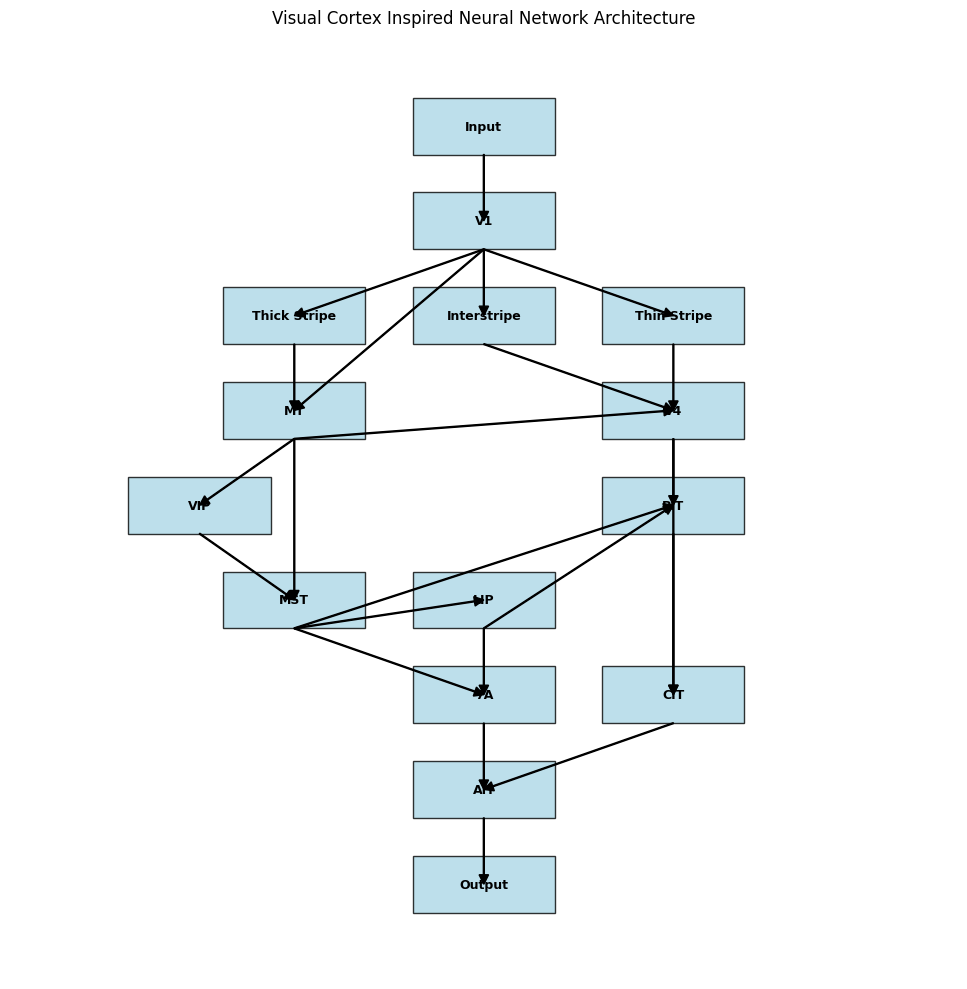

Using cpu device
VisualCortexModel(
  (v1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (thick_stripe): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (interstripe): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (thin_stripe): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (mt): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (vip): Sequential(
    (0): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (mst): Sequential(
    (0): Conv2d(80, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (lip): Sequential(
    (0): Conv2d(40, 32, k

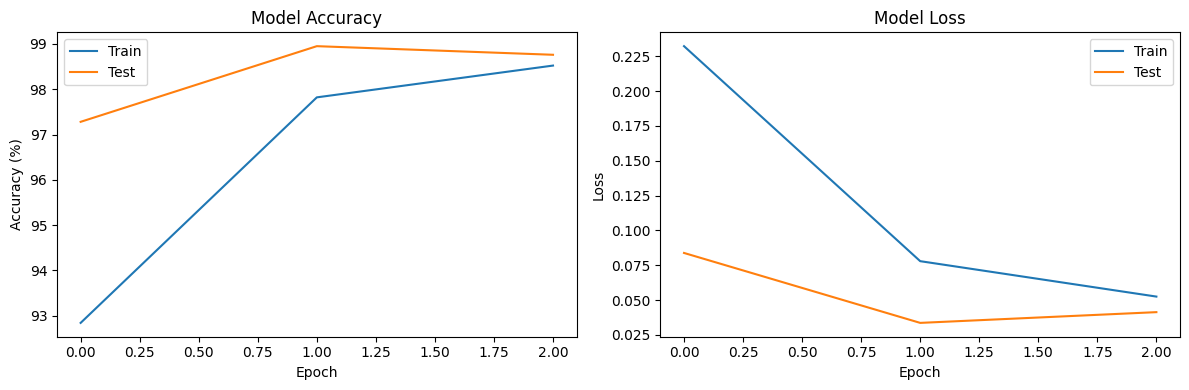

Model saved as 'visual_cortex_model.pth'


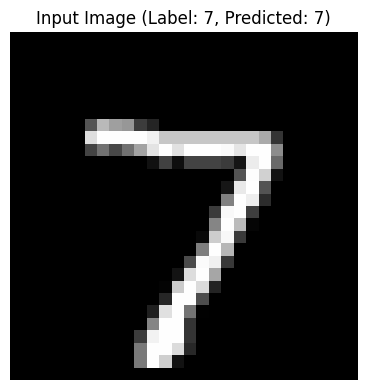

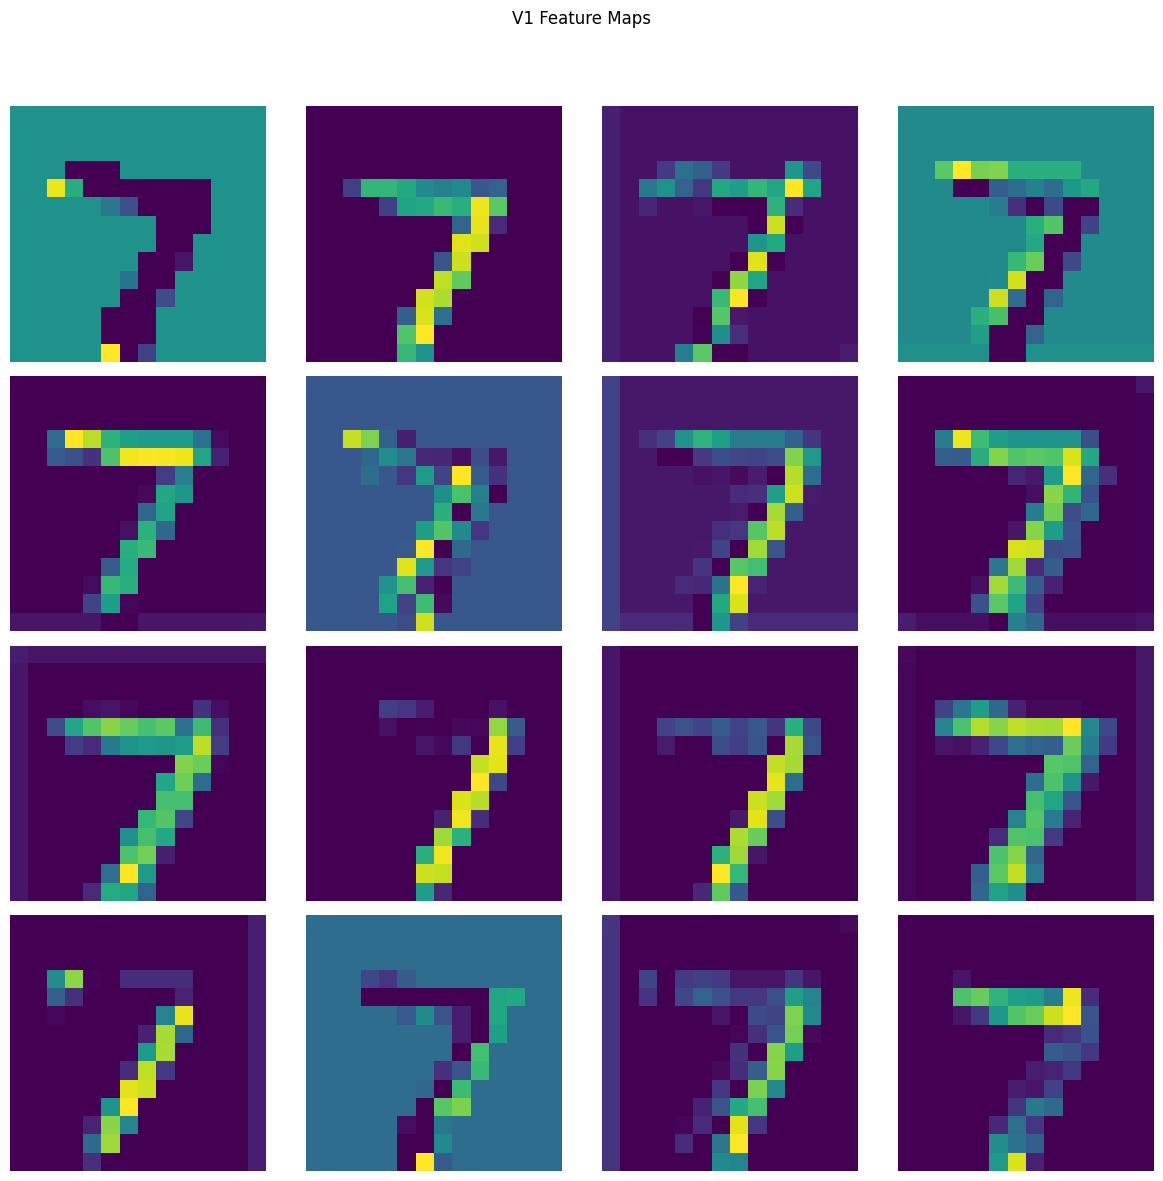

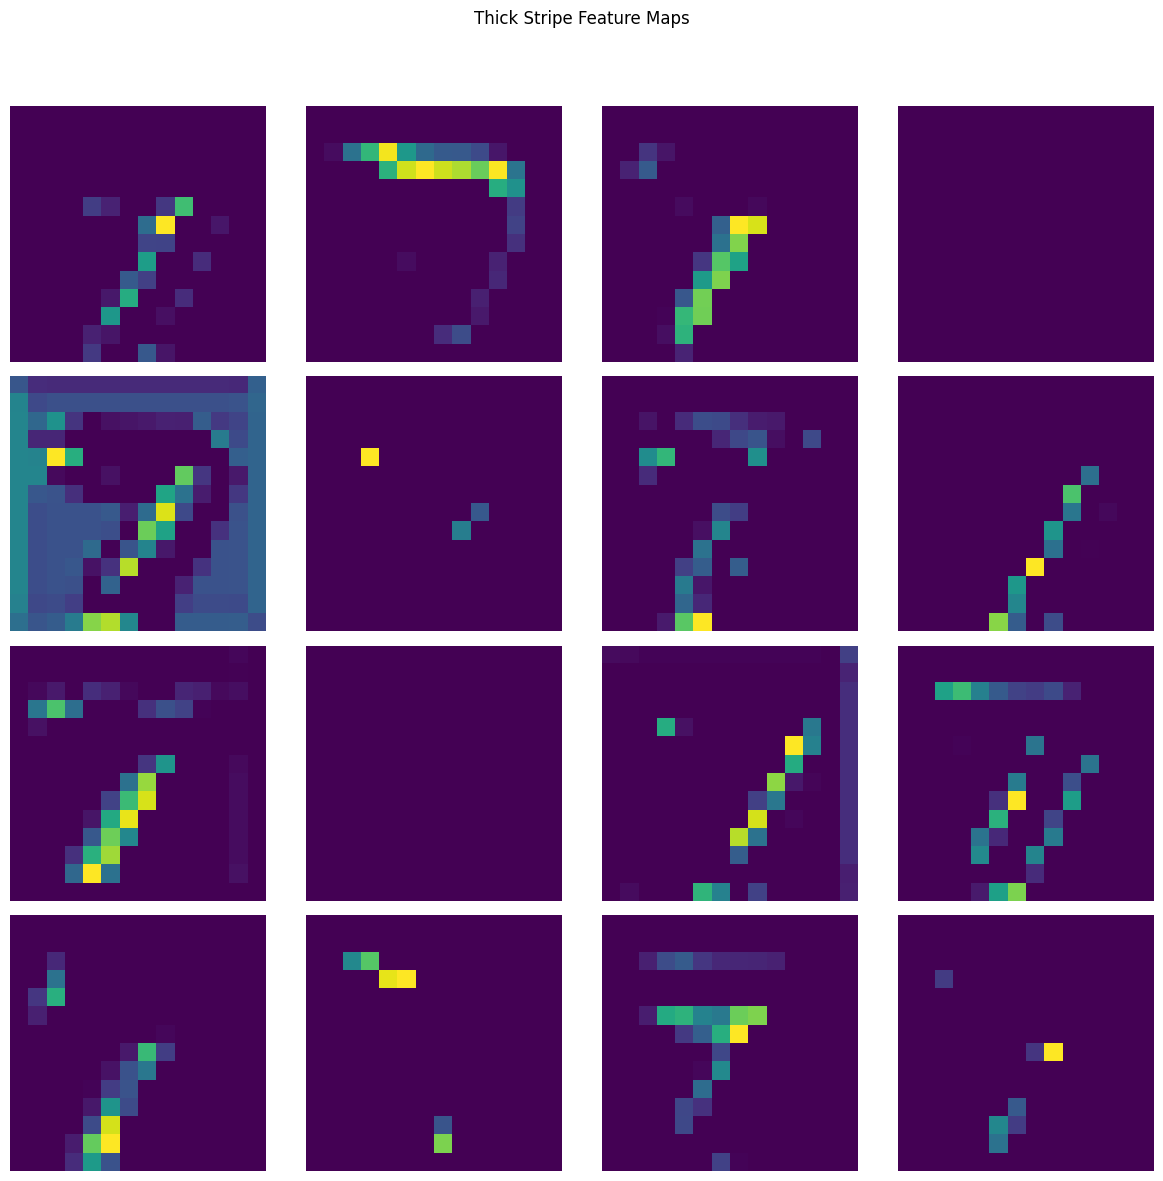

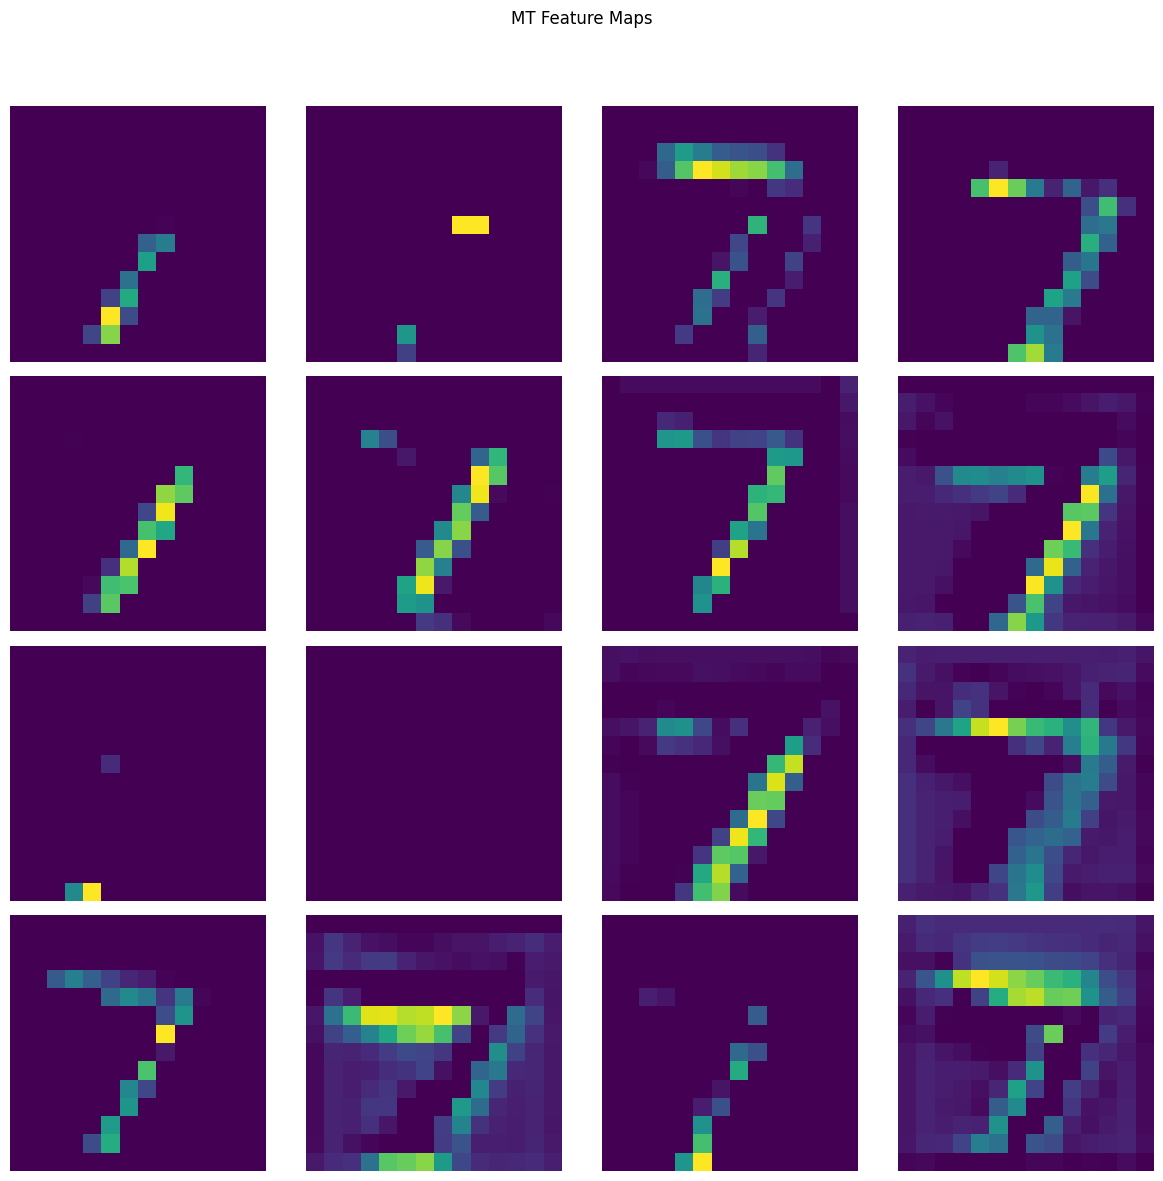

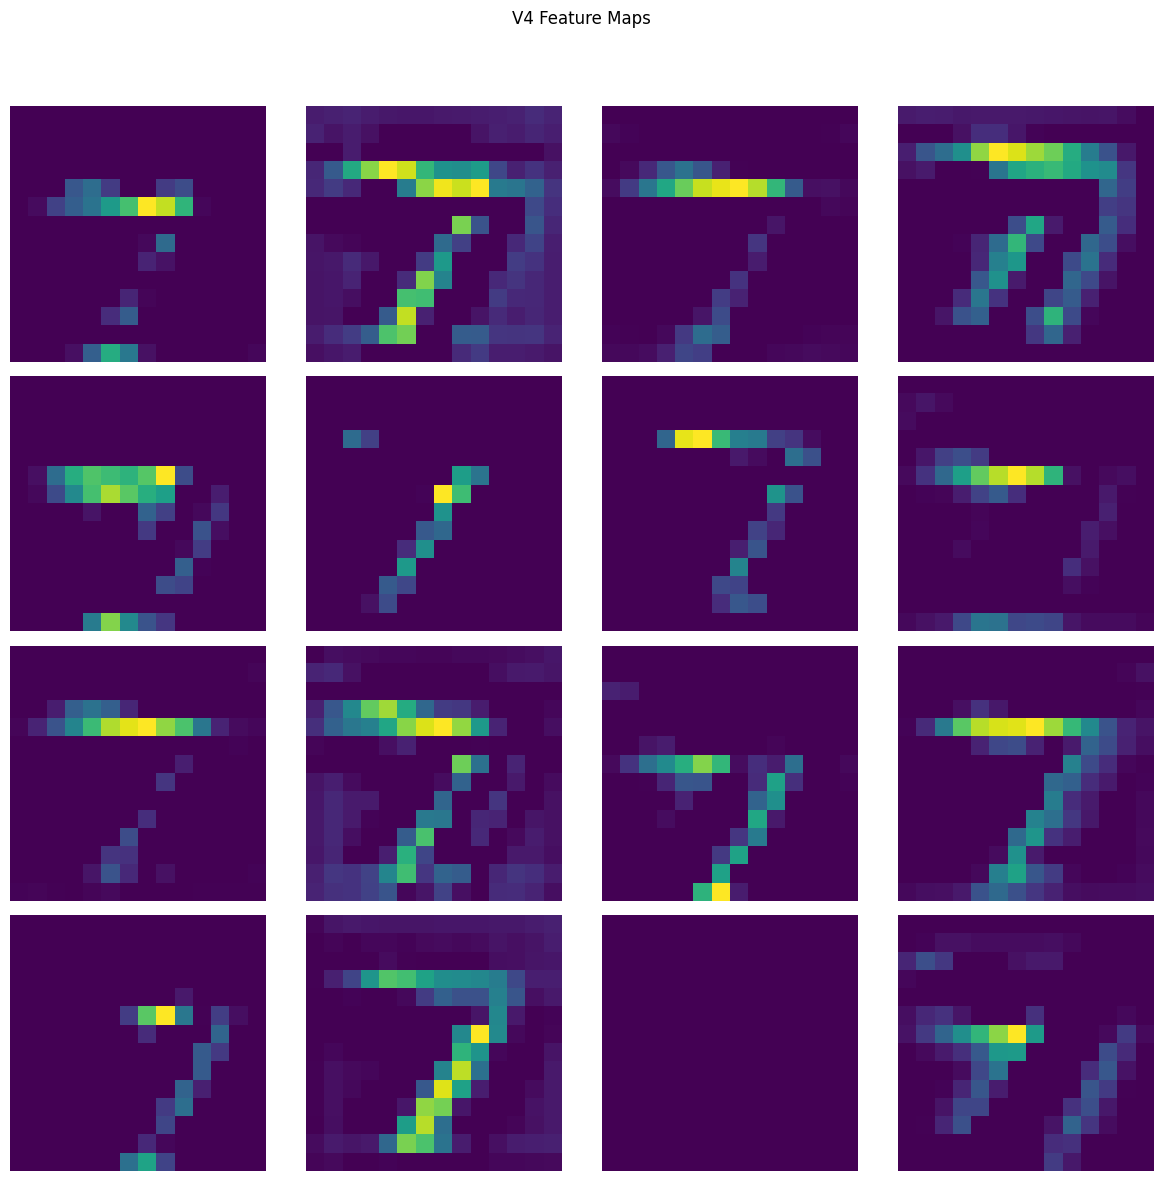

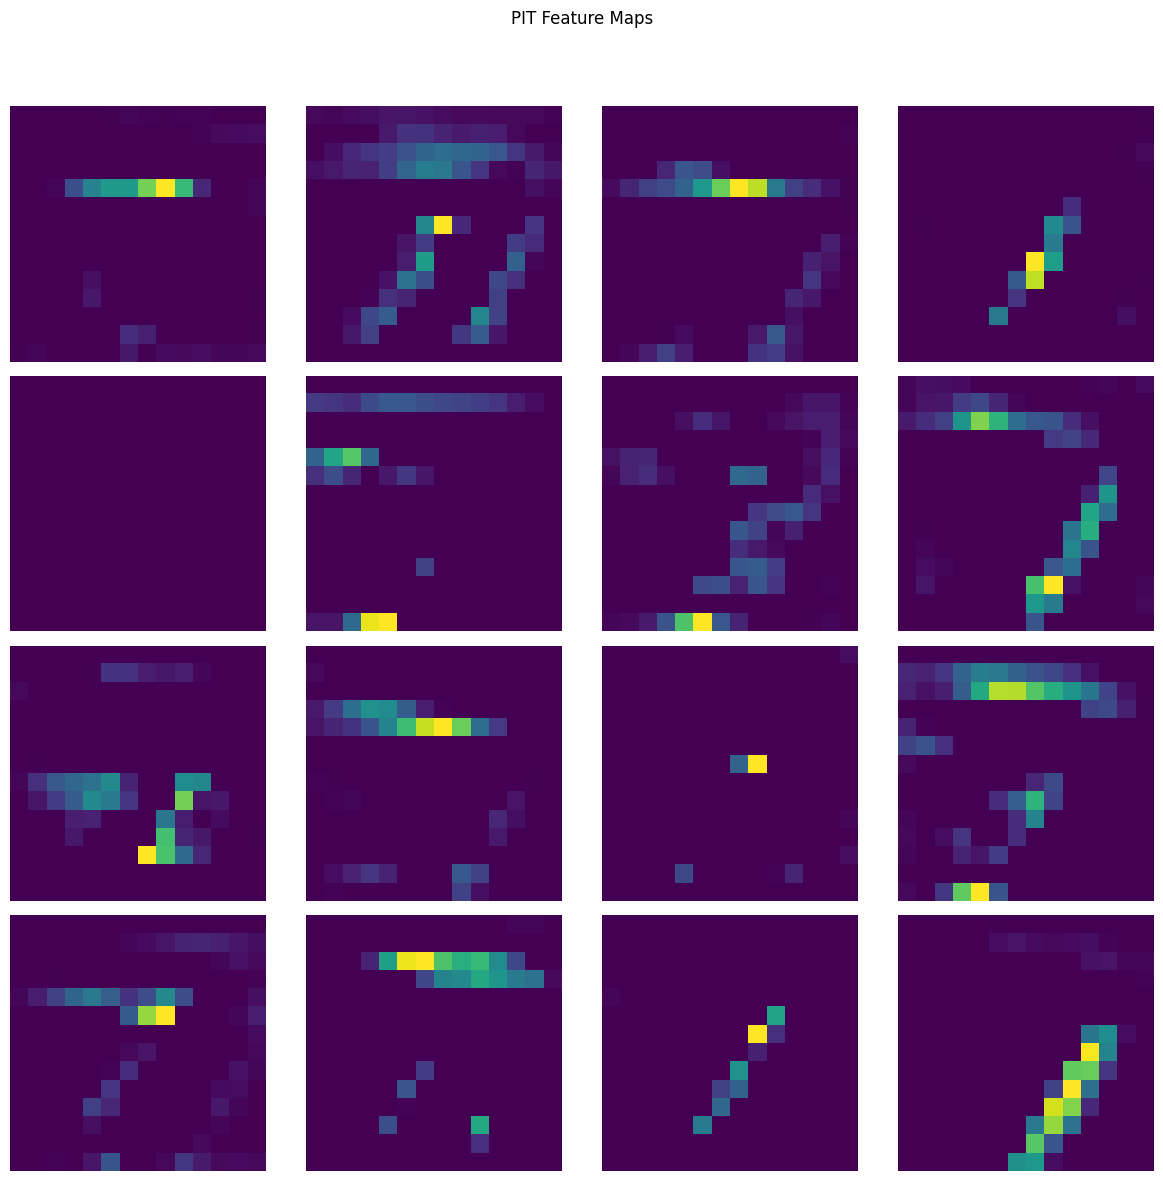

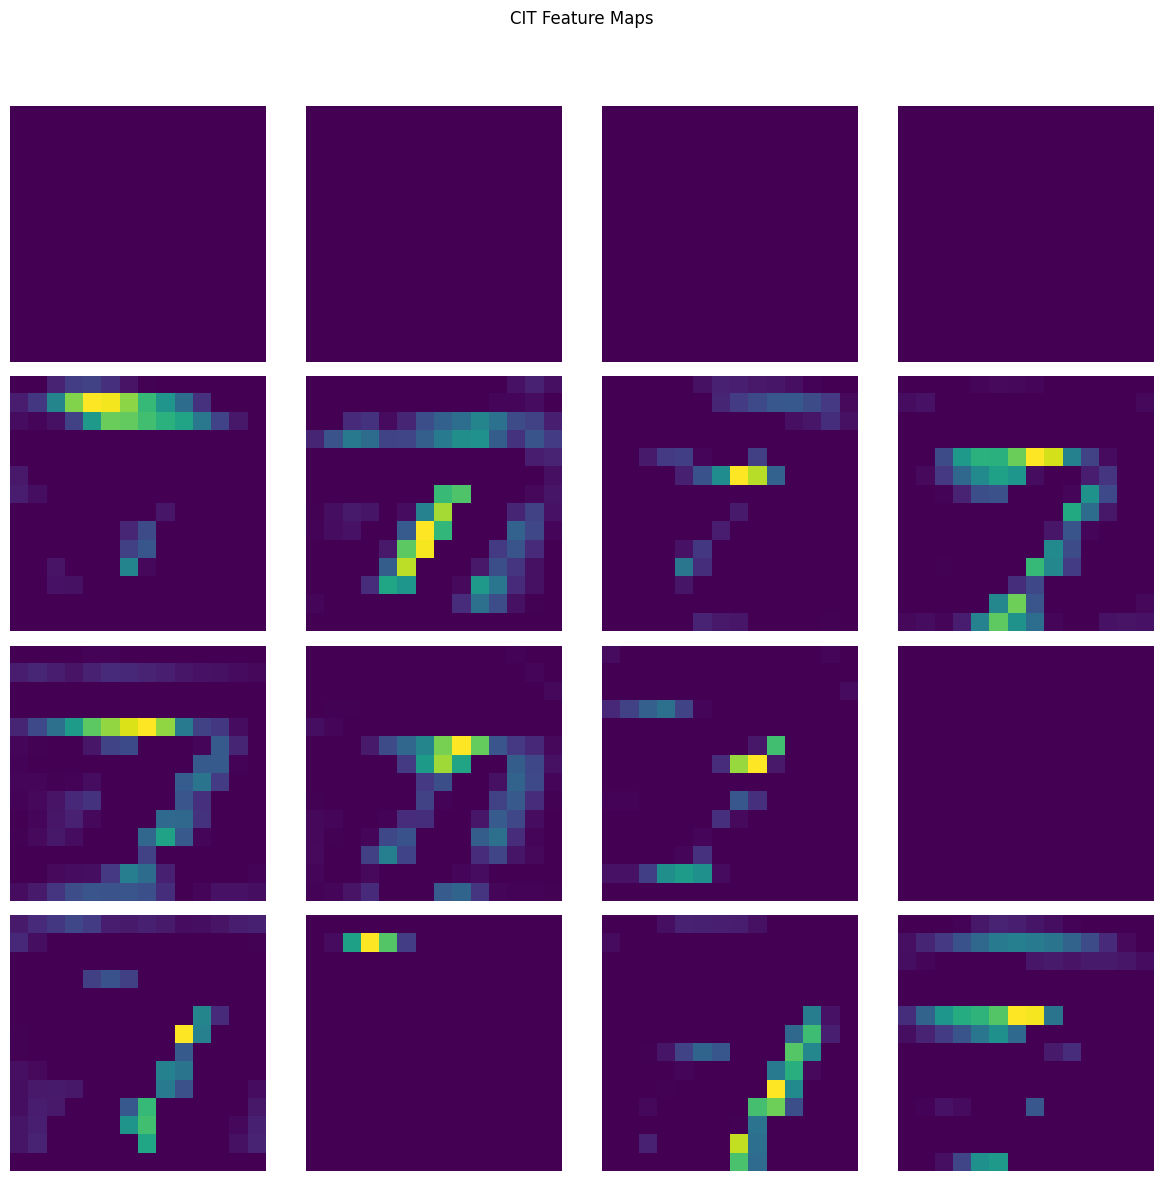

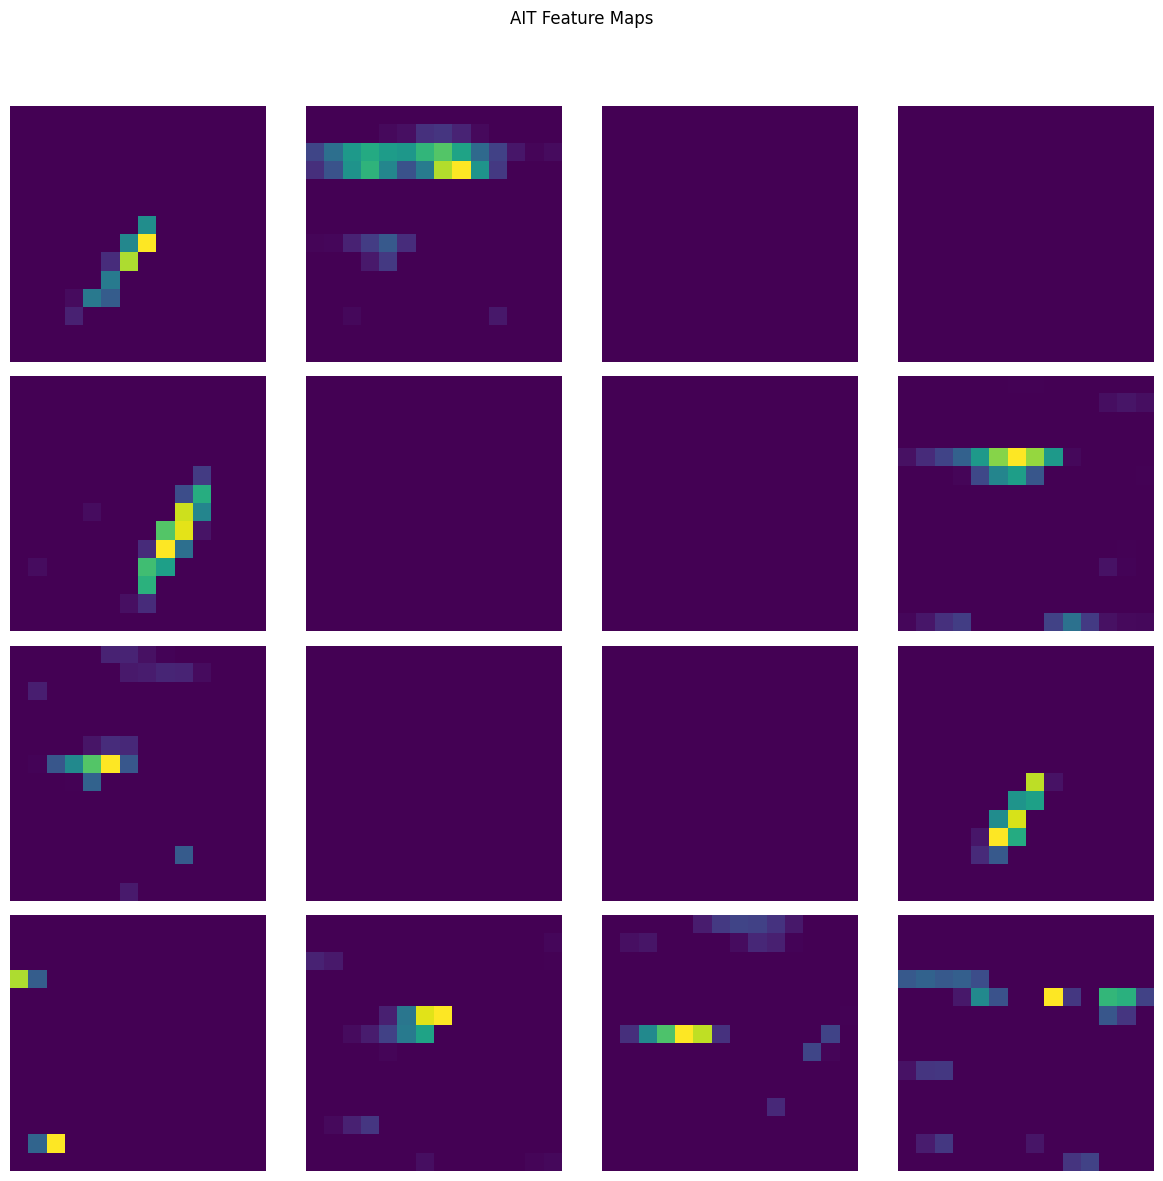

In [ ]:
# Visualize the model architecture
visualize_architecture()

# Train and evaluate the model
model, device, test_loader = train_and_evaluate(epochs=3)

# Visualize features from different visual areas
visualize_features(model, device, test_loader)

model-arch.svg